In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.stats import gumbel_r
from scipy.optimize import curve_fit

In [2]:
# damage ratios dataset
df = pd.read_csv('DAMAGE_RATIOS.csv')

In [3]:
# Drop NaNs
df = df.dropna()

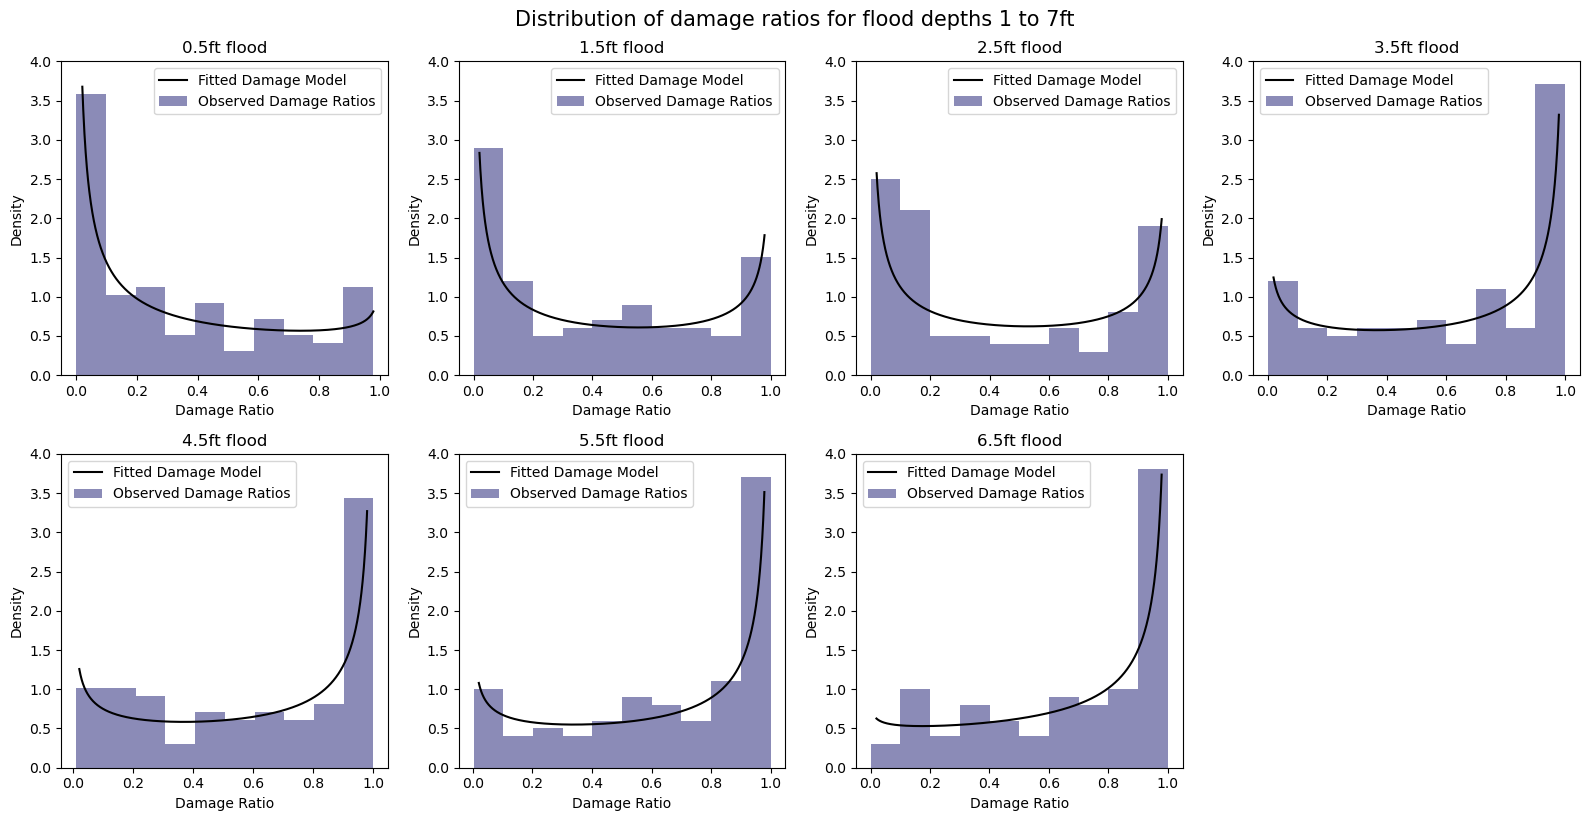

In [4]:
# Plotting damage ratios with fitted beta distributions
plt.figure(figsize = (16,8))
ex = np.arange(0.02,0.98,0.001)
params = np.zeros((7,4)) # INitializing params array for each flood depth
for i,x in enumerate(df.columns):
    plt.subplot(2,4,i+1)
    plt.hist(df[x], density = True, color = 'midnightblue', alpha = 0.5)
    plt.xlabel('Damage Ratio')
    plt.ylabel('Density')
    plt.title(f'{i+0.5}ft flood')
    a,b,loc,scale = beta.fit(df[x], floc = 0, fscale = 1.0001)
    y = beta.pdf(ex,a,b,loc,scale)
    plt.plot(ex,y, 'k-')
    plt.ylim(0,4)
    plt.legend(['Fitted Damage Model','Observed Damage Ratios'])
    params[i,:] = [a,b,loc,scale] # saving params of beta distribution in params array
plt.tight_layout()
plt.suptitle('Distribution of damage ratios for flood depths 1 to 7ft', y = 1.02, fontsize = 15)

plt.savefig('damage.png', transparent = True)

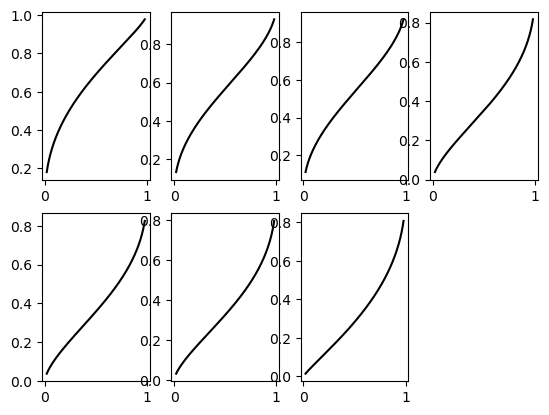

In [5]:
for i,x in enumerate(df.columns):
    plt.subplot(2,4,i+1)
    a,b,loc,scale = beta.fit(df[x], floc = 0, fscale = 1.0001)
    y = beta.cdf(ex,a,b,loc,scale)
    plt.plot(ex,y, 'k-')
    

In [6]:
# Estimating damages over 10000 properties using Monte Carlo simulation

mean_damage = np.zeros((1,7)) # Initialise mean damage array
damages = np.zeros((10_000,7)) # Initialise damage array for 10000 properties and 7 flood depths
for i in range(7):
    np.random.seed(60)
    x = np.random.rand(10000) # 10000 pseudo random numbers
    icdf = beta.ppf(x,params[i,0],params[i,1], params[i,2], params[i,3]) # Inverse CDF function to get damage ratios from fitted beta distribution
    damage = icdf*500_000 # Total simulated damages for 10,000 homes in USD
    damages[:,i] = damage
    mean_damage[0,i] = damage.mean()


In [7]:
insurance_payoff_B = ((damages >= 50_000)&(damages <= 300_000))*(damages - 50_000) + (damages >300_000)*250_000

In [8]:
# Cost of damages after purchasing insurance
# Calculating insurance costs and payoff
# Annual premiums of each insurance
premium_B = 0.8*1500
premium_A = 1500
premium_C = 0.6*1500
ded_A = 1250
ded_B = 5000
ded_C = 10000
premiums = np.array([0, premium_A, premium_B, premium_C])

# Damages covered by insurance for each insurance for 10,000 homes for each flood depth
insurance_payoff_A = ((damages >= ded_A)&(damages <= 250_000))*(damages-ded_A) + (damages > 250_000)*250_000
insurance_payoff_B = ((damages >= ded_B)&(damages <= 250_000))*(damages - ded_B) + (damages >250_000)*250_000
insurance_payoff_C = ((damages >= ded_C)&(damages <= 250_000))*(damages - ded_C) + (damages >250_000)*250_000

# Cost to homeowner after purchasing insurance for 10,000 homes for each flood depth
insured_cost_B = damages - insurance_payoff_B 
insured_cost_A = damages - insurance_payoff_A 
insured_cost_C = damages - insurance_payoff_C 

# Mean cost of homeowner after purchasing insurance for each flood depth
mean_insured_cost_B = insured_cost_B.mean(axis = 0)
mean_insured_cost_A = insured_cost_A.mean(axis = 0)
mean_insured_cost_C = insured_cost_C.mean(axis = 0)

In [9]:
# Coefficients of fitted polynomial
a, b, c = 6e-11, -7e-6, 0.057
x = np.arange(100_000, 500_000, 100) # streamflow range for plotting fitted model
y = a*(x**2) + b*x + c 
# simFlows is consists average depths in ROI for peak flows simulated on HECRAS
simFlows = pd.read_csv('simulatedFlows.csv')

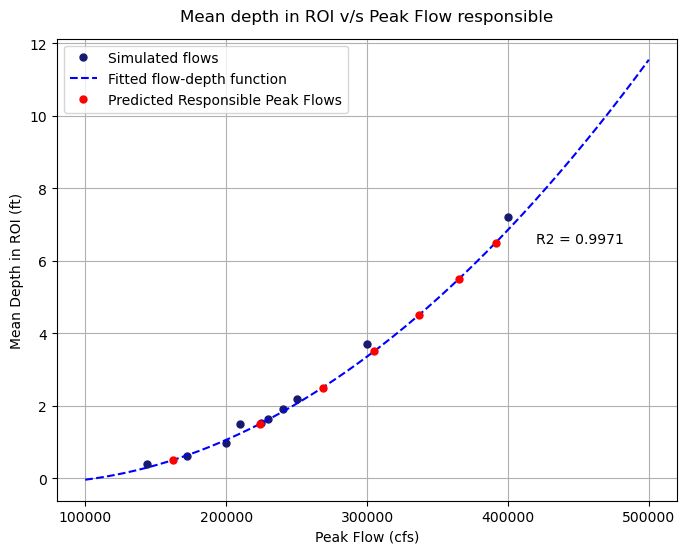

In [10]:
# Use fitted model to solve quadratic polynomial to get peak flow for 7 flood depths
def get_flow(depth):
    c1 = c - depth
    d = b**2 - 4*a*c1
    flow = (-b + np.sqrt(d))/(2*a)
    return flow

depth_flow = {}
for depth in [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]:
    depth_flow[int(depth - 0.5)] = get_flow(depth)
    
plt.figure(figsize = (8,6))
plt.grid()

plt.plot(simFlows['Peak Flow'], simFlows['True Depth'],
         '.', color = 'midnightblue', markersize = 10,
         label = 'Simulated flows')

plt.plot(x, y, 'b--', label = 'Fitted flow-depth function')

plt.plot(list(depth_flow.values()), np.array(list(depth_flow.keys()))+0.5, 
         '.', color = 'red', markersize = 10, 
         label = 'Predicted Responsible Peak Flows')

plt.xlabel('Peak Flow (cfs)')
plt.ylabel('Mean Depth in ROI (ft)')
plt.xticks(np.arange(100_000, 600_000, 100_000),np.arange(100_000, 600_000, 100_000)) 
plt.text(420_000,6.5,'R2 = 0.9971')
plt.legend()
plt.title('Mean depth in ROI v/s Peak Flow responsible', y = 1.02)
plt.savefig('depth-flow.png', transparent = True)
    

In [14]:
depth_flow = {0:162190,1:224022,2:268380,3:304882,4:336637,5:365122,6:391179}
g_loc = 80156.190 # Location param for gumbel distribution of annual max streamflows
g_scale = 20200.864 # Scale param for gumbel distribution of annual max streamflows
depths = np.arange(0.5, 7, 1)
flows = list(depth_flow.values())

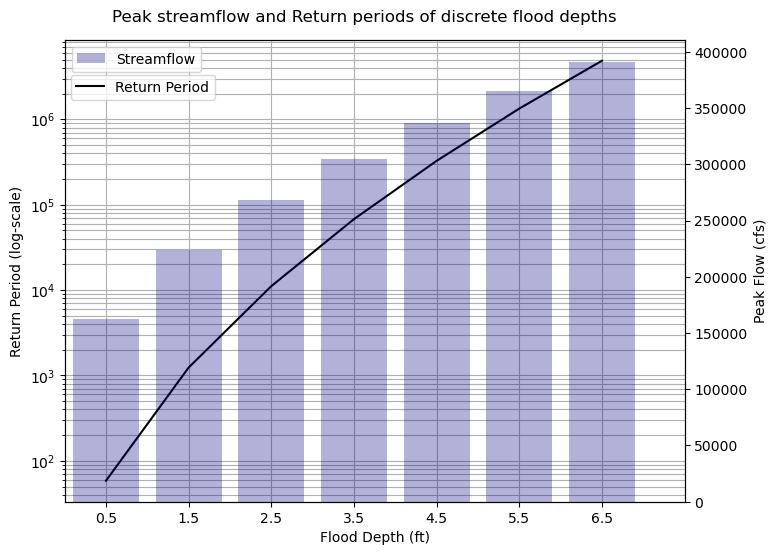

In [15]:
returns = 1/gumbel_r.sf(flows, loc = g_loc, scale = g_scale)

str_flows = [str(x) for x in flows]
fig, ax1 = plt.subplots(figsize = (8,6))
plt.grid(which = 'both')
ax2 = ax1.twinx()
ax2.bar(x = depths, height = flows, color = 'navy', alpha = 0.3)
ax2.set_ylabel('Peak Flow (cfs)')
ax1.semilogy(depths, returns, 'k')
ax1.set_xticks(depths)
ax1.set_xlabel('Flood Depth (ft)')
ax1.set_ylabel('Return Period (log-scale)')
ax1.legend(['Return Period'], loc = (0.01,0.87))
ax2.legend(['Streamflow'])
ax1.set_xlim(0, 7.5)

plt.suptitle('Peak streamflow and Return periods of discrete flood depths', y = 0.93)
plt.savefig('returns.png', transparent = True)

In [16]:
# Exceedance probability of each streamflow corresponding to flood depth
exceedance = np.array([gumbel_r.sf(depth_flow[i], loc = g_loc, scale = g_scale) for i in range(7)]).reshape(7,1)

# Annual average loss per homeowner
annual_average_loss = float(np.dot(mean_damage, exceedance)) # without insurance
annual_average_loss_insurance_A = float(np.dot(mean_insured_cost_A, exceedance)) # with insurance A
annual_average_loss_insurance_B = float(np.dot(mean_insured_cost_B, exceedance)) # with insurance B
annual_average_loss_insurance_C = float(np.dot(mean_insured_cost_C, exceedance)) # with insurance C


In [19]:
annual_average_losses = [annual_average_loss,annual_average_loss_insurance_C,annual_average_loss_insurance_B, annual_average_loss_insurance_A ]
annual_average_losses = np.array(annual_average_losses) 
annual_average_losses

array([3068.37285173,  843.48423259,  795.29087261,  755.8331148 ])

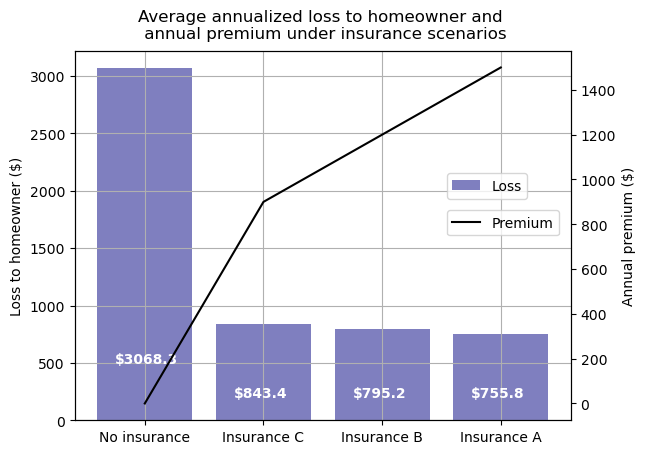

In [22]:
fig, ax1 = plt.subplots()
ax1.grid()
ax1.bar(x = np.arange(4), height = annual_average_losses, color = 'navy', alpha = 0.5)
plt.xticks(np.arange(4), ['No insurance', 'Insurance C', 'Insurance B', 'Insurance A'])
plt.text(-0.25,500, '$'+str(annual_average_loss)[:6], color = 'white', weight = 'bold')
plt.text(0.75,200, '$'+str(annual_average_loss_insurance_C)[:5], color = 'white', weight = 'bold')
plt.text(1.75,200, '$'+str(annual_average_loss_insurance_B)[:5], color = 'white', weight = 'bold')
plt.text(2.75,200, '$'+str(annual_average_loss_insurance_A)[:5], color = 'white', weight = 'bold')

ax2 = ax1.twinx()
ax2.plot(np.arange(4), [0, premium_C, premium_B, premium_A], 'k-')
ax2.set_ylabel('Annual premium ($)')
ax1.set_ylabel('Loss to homeowner ($)')
ax2.legend(['Premium'], loc = (0.75,0.5))
ax1.legend(['Loss'], loc = (0.75,0.6))
plt.title('Average annualized loss to homeowner and \n annual premium under insurance scenarios', y = 1.01)
plt.savefig('aal_scenarios.png', transparent = True)

In [24]:
nums = np.arange(0,1,0.001)
isf = gumbel_r.isf(nums, loc = g_loc, scale = g_scale)

Text(0, 0.5, 'Streamflow (cfs)')

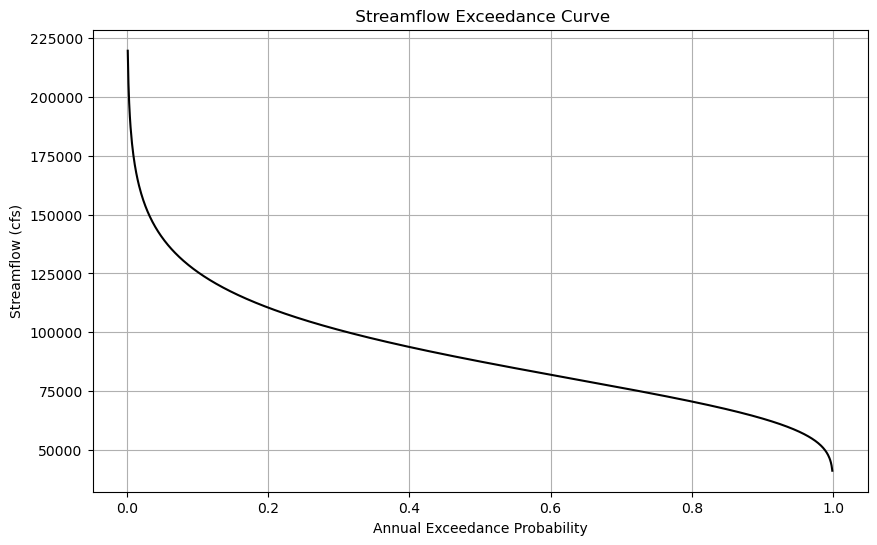

In [25]:
plt.figure(figsize = (10,6))
plt.grid()
plt.plot(nums, isf, color = 'k')
plt.title(' Streamflow Exceedance Curve')
plt.xlabel('Annual Exceedance Probability')
plt.ylabel('Streamflow (cfs)')

In [27]:
from seaborn import kdeplot
from seaborn import heatmap

In [28]:
def kde(data, label):
    plt.figure(figsize = (12,6))
    for i in range(7):
        plt.subplot(2,4,i+1)
        kdeplot(data[:,i], label = label, fill = True, color = 'midnightblue')
        plt.xlim(0,600_000)
        plt.xticks(np.arange(0,700000,200000))
        plt.title(f'{i+0.5}ft Flood')    
        plt.tight_layout()
        plt.xlabel('Cost to homeowner ($)')
        plt.ylabel('Probability Density')
    plt.suptitle(label, y = 1)

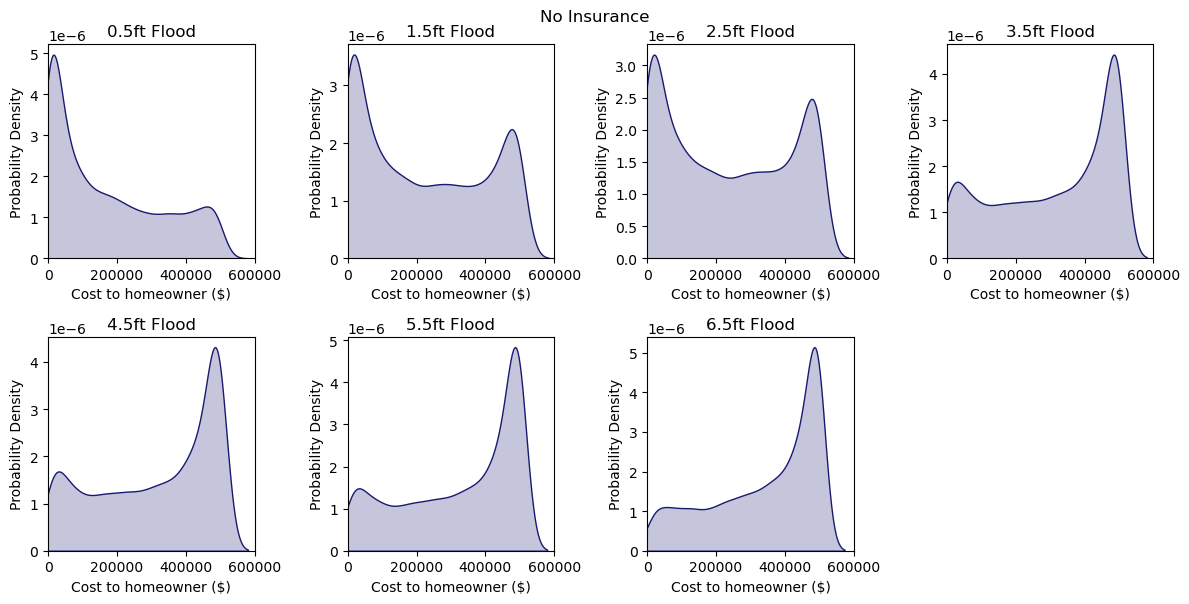

In [32]:
kde(damages, 'No Insurance')


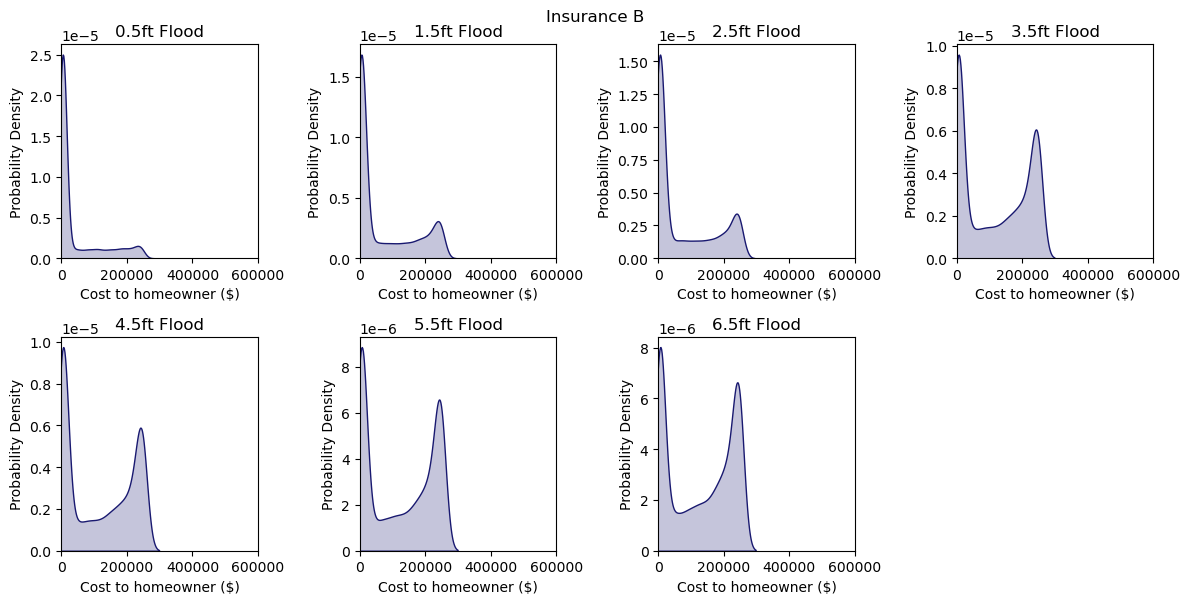

In [34]:
kde(insured_cost_B , 'Insurance B')

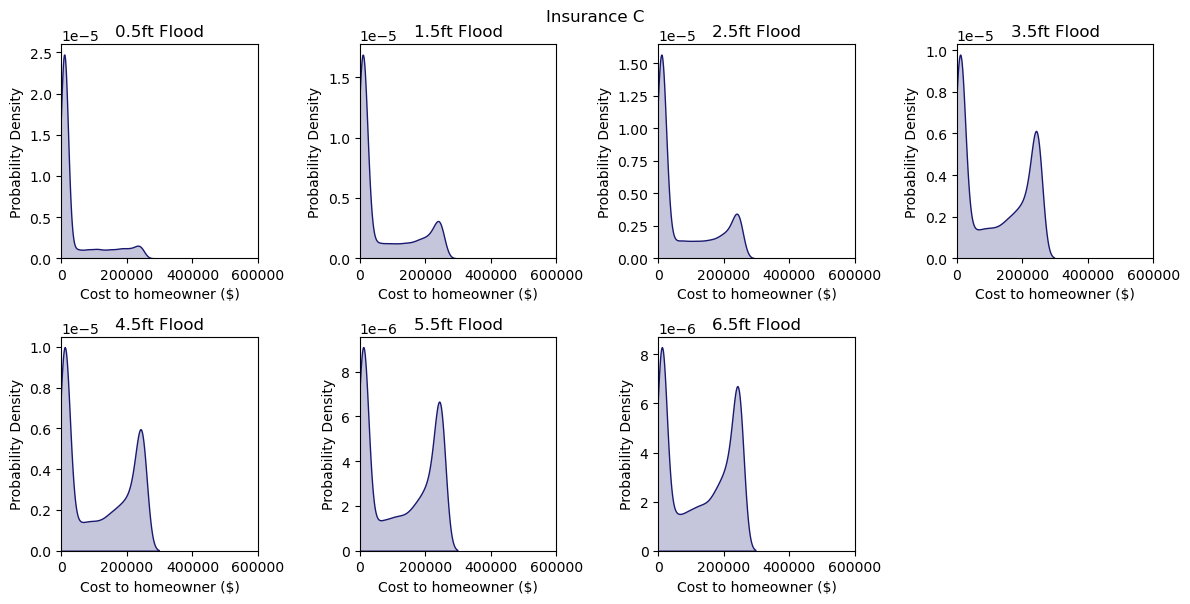

In [35]:
kde(insured_cost_C, 'Insurance C')

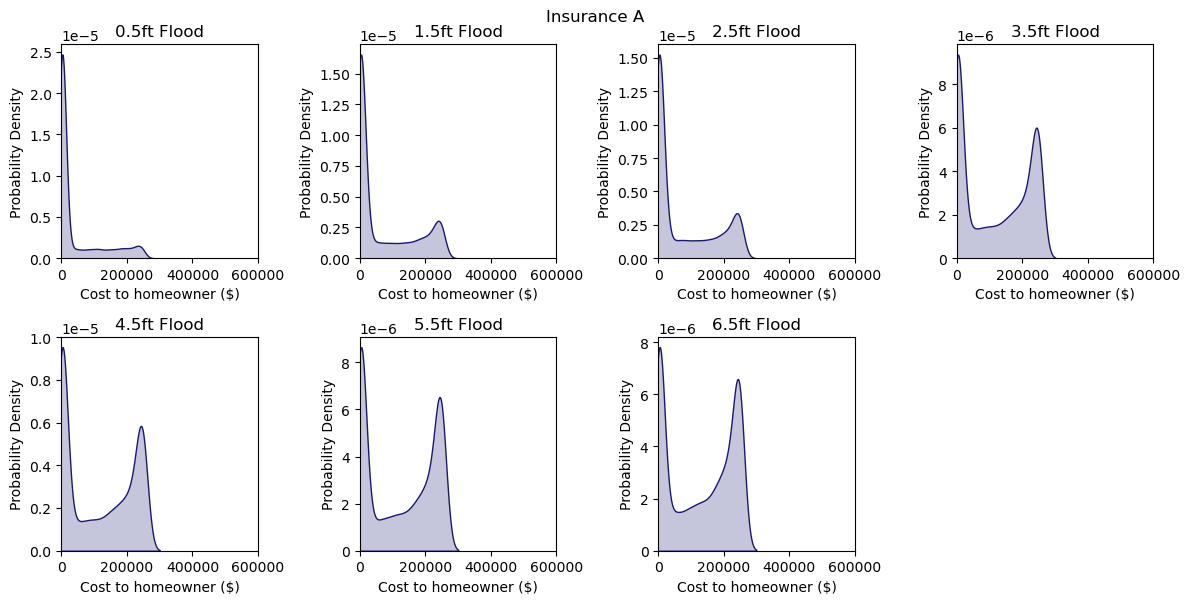

In [265]:
kde(insured_cost_A , 'Insurance A')

In [36]:
mean_insured_cost_A = insured_cost_A.mean(axis = 0)
mean_insured_cost_B = insured_cost_B.mean(axis = 0)
mean_insured_cost_C = insured_cost_C.mean(axis = 0)
damages_cost = damages.mean(axis = 0)
mean_insured_costs = np.zeros((4,7))
mean_costs = [damages_cost, mean_insured_cost_C, mean_insured_cost_B , mean_insured_cost_A]
for i,x in enumerate(mean_costs):
    mean_insured_costs[i,:] = x

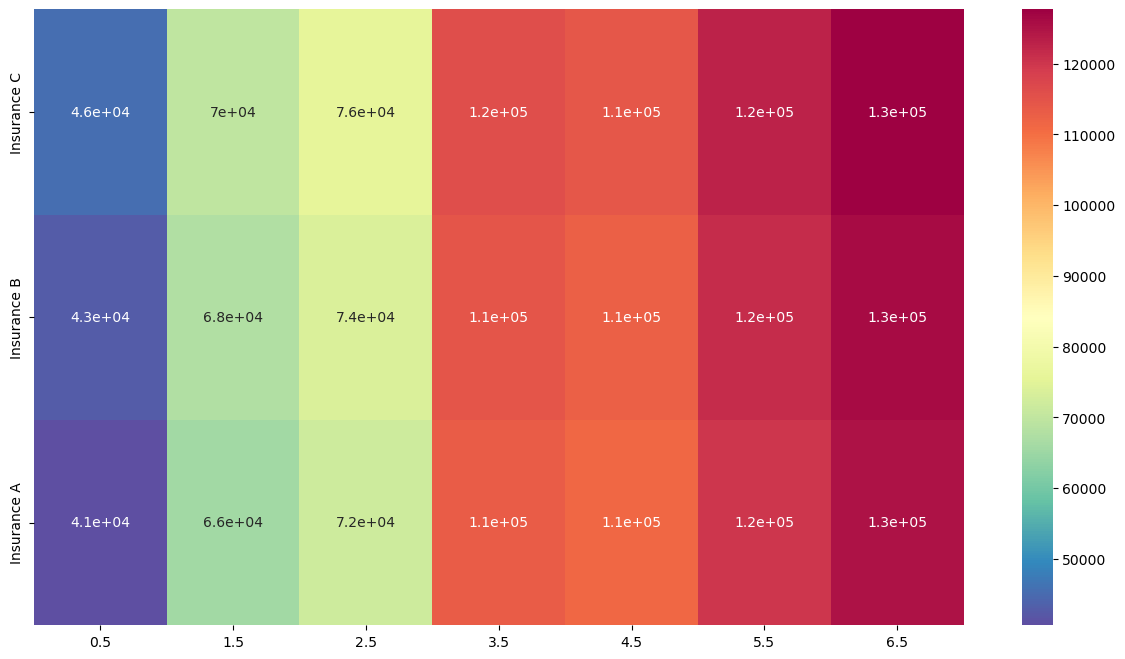

In [37]:
plt.figure(figsize = (15,8))
heatmap(mean_insured_costs[1:,:], cmap = 'Spectral_r', annot = True)
plt.xticks(np.arange(0.5,7.5), depths)
plt.yticks([0.5,1.5,2.5], ['Insurance C', 'Insurance B', 'Insurance A'])
plt.savefig('avgCosts.png', transparent = True)

In [38]:
expected_cost_A = insured_cost_A@exceedance
expected_cost_B = insured_cost_B@exceedance
expected_cost_C = insured_cost_C@exceedance
expected_cost = damages@exceedance

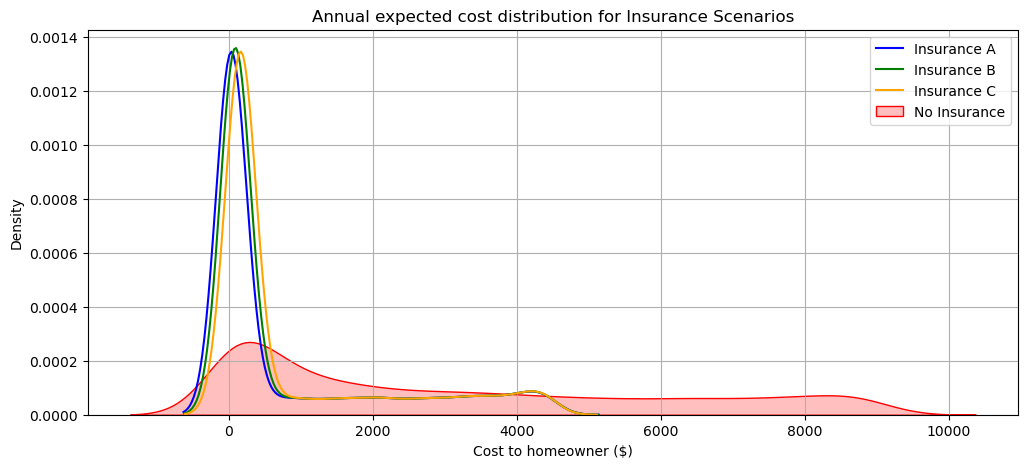

In [39]:
plt.figure(figsize = (12,5))
plt.grid()
kdeplot(expected_cost_A.squeeze(), fill = False, color = 'blue', label = 'Insurance A')
kdeplot(expected_cost_B.squeeze(), fill = False, color = 'green', label = 'Insurance B')
kdeplot(expected_cost_C.squeeze(), fill = False, color = 'orange', label = 'Insurance C')
kdeplot(expected_cost.squeeze(), fill = True, color = 'red', label = 'No Insurance')
plt.xlabel('Cost to homeowner ($)')
plt.legend()
plt.title('Annual expected cost distribution for Insurance Scenarios')
plt.savefig('simulatedAnnual.png', transparent = True)